## Timing our algorithms

In [1]:
import time, random
import pandas as pd
import seaborn as sns
import matplotlib as plt
import sys

In [8]:
from parsers.read_fasta import read_fasta_file
from parsers.read_fastq import read_fastq_file
from search_st import search_suffix
import search_st

In [44]:
def dna(length=int(), letters="CGTA"):
    return''.join(random.choices(letters, k=length))

def create_one_fasta(n):
    name = f"test_files/n_{n}.fasta"
    f = open(name, "w")
    
    f.write('>Seq' + str(1) + '\n' + dna(n) + '\n')
    
    f.close()

    return name

def create_many_fasta(start, stop, step):
    name = f"test_files/n_{stop}.fasta"
    f = open(name, "w")
    counter = 1

    for i in range(start, stop, step):
        f.write('>Seq' + str(counter) + '\n' + dna(i) + '\n')
        counter += 1
    f.close()

    return name

def create_one_fastq(m):
    name = f"test_files/m_{m}.fastq"
    f = open(name, "w")
    f.write(
        '@' + 'Seq' + str(1) + '\n' + 
        dna(m) + '\n' + 
        '+' + '\n' + 
        '~' * m + '\n')
    f.close()
    
    return name

def create_many_fastq(start, stop, step):
    name = f"test_files/m_{stop}.fastq"
    f = open(name, "w")

    counter = 1

    for i in range(start, stop, step):
        f.write(
            '@' + 'Seq' + str(counter) + '\n' + 
            dna(i) + '\n' + 
            '+' + '\n' + 
            '~' * i + '\n'
        )
        counter += 1
    
    f.close()
    
    return name


In [42]:
def time_search(n, m):
    df = pd.DataFrame(range(20, m, int(m/10)), columns=['m'])
    fastq_file = create_many_fastq(20, m, int(m/10))
    fasta_file = create_one_fasta(n)

    fastq = read_fastq_file(fastq_file)
    fasta = read_fasta_file(fasta_file)
    times = []

    if len(fasta) < 0 or len(fastq) < 0:
        return "Problems with either fasta or fastq file"

    flag, mapq, pnext, tlen = 0,0,0,0
    rnext = "*"

    for x in fasta.items():
        rname = x[0]
        tree = None
        tree = search_st.SuffixTree()
        tree.root.children = [None, None, None, None, None]
        tree.insert(x[1])


        for p in fastq.items():
            start = time.time()
            qname = p[0]
            substring = p[1][0]
            cigar = str(len(substring)) + "M"
            qual = p[1][1]

            seq = [tree.alpha[a] for a in substring]

            matches = tree.search_rec(tree.root, 0, 0, seq)

            if matches is not None:
                for match in matches:
                    pos = int(match) + 1
                    print(f"{qname}\t{flag}\t{rname}\t{pos}\t{mapq}\t{cigar}\t{rnext}\t{pnext}\t{tlen}\t{substring}\t{qual}", file = sys.stdout)
            
            end = time.time()
            difference = end - start
            times.append(difference)

    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['m']

    return df


In [41]:
def time_construction(n, m):
    df = pd.DataFrame(range(20, n, int(n/10)), columns=['n'])
    fastq_file = create_one_fastq(m)
    fasta_file = create_many_fasta(20, n, int(n/10))

    fastq = read_fastq_file(fastq_file)
    fasta = read_fasta_file(fasta_file)
    times = []

    if len(fasta) < 0 or len(fastq) < 0:
        return "Problems with either fasta or fastq file"

    flag, mapq, pnext, tlen = 0,0,0,0
    rnext = "*"

    for x in fasta.items():
        rname = x[0]
        tree = None

        start = time.time()
        tree = search_st.SuffixTree()
        tree.root.children = [None, None, None, None, None]
        tree.insert(x[1])

        end = time.time()
        difference = end - start
        times.append(difference)


        for p in fastq.items():
            qname = p[0]
            substring = p[1][0]
            cigar = str(len(substring)) + "M"
            qual = p[1][1]

            seq = [tree.alpha[a] for a in substring]

            matches = tree.search_rec(tree.root, 0, 0, seq)

            if matches is not None:
                for match in matches:
                    pos = int(match) + 1
                    print(f"{qname}\t{flag}\t{rname}\t{pos}\t{mapq}\t{cigar}\t{rnext}\t{pnext}\t{tlen}\t{substring}\t{qual}", file = sys.stdout)
    
    df['Time'] = times

    df['Time/Expected time'] = df['Time']/df['n']**2
    return df

In [58]:
n = 100000
m = 1000

In [57]:
df_search = time_search(n, m)

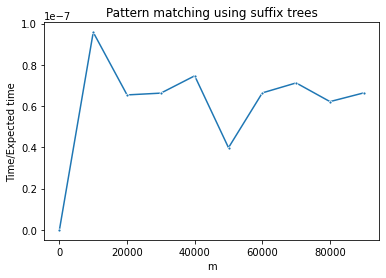

In [51]:
h = sns.lineplot(x = 'm', y = 'Time/Expected time', marker = '.',
                    data = df_search)
h.set_title('Pattern matching using suffix trees')
h.figure.savefig('../figures/search_st.pdf')

In [59]:
df_stc = time_construction(n, m)

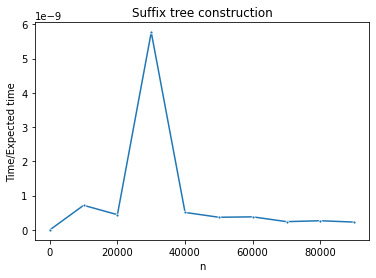

In [60]:
h = sns.lineplot(x = 'n', y = 'Time/Expected time', marker = '.',
                    data = df_stc)
h.set_title('Suffix tree construction')
h.figure.savefig('../figures/st_construction.pdf')